&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Image Caption Generator**<br><br>
```This project is about generating a caption given an image.```<br>

<br>```This Notebook will have 3 parts:- ```

---



```1)  Processing the Captions and Converting them into Text Features.```<br>
```2)  Extracting Features from Images  using Xception Model.```<br>
```3)  Fitting the Model with above Features.```<br>







---



---



In [2]:
path="Enter Folder Path Here"

import os
import cv2
import time
import string

import numpy as np 
import pandas as pd
from PIL import Image
from collections import Counter 
from matplotlib import pyplot
from tqdm.notebook import  tqdm


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception, preprocess_input,decode_predictions

Using TensorFlow backend.


**Reading DataFrame and Columns**

```Here is our dataset.```<br>
```It has two columns.```<br>
```The "image" column contains the name of image.These images are stored in separate folder.```<br>
```The "caption" column contains the caption for the image.```<br>

In [3]:
data=pd.read_csv(text_path+"captions.csv")
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n


```There are multiple captions belonging to an image but all of them are pretty much similar in describing the image.```<br>```So, We will be training all those captions with their corresponding image.```

#1.**Text Processing for Captions**

1.1 **Storing captions in a dictionary**

> ```1.1.1 "img_desc_dict" is a dictionary which have images as keys and their captions as list of its values.```

In [0]:
img_desc_dict={}
for image,caption in zip(data.image.values,data.caption.values):
    if image in img_desc_dict.keys():
        img_desc_dict[image].append(caption)
    else:
        img_desc_dict[image]=[caption]

>```1.1.2 Accessing our dictionary```





In [5]:
img_desc_dict["3729405438_6e79077ab2.jpg"]

['A bicycler balances his bike on a rail .\n',
 'A biker is riding down the stairs on his bike at night .\n',
 'A boy rides his red bicycle down the handrail of a staircase in a city .\n',
 'A guy grinding a rail in a park on his bike\n',
 'A trick bicyclist grinds down a handrail .\n']

1.2 **Text Preprocessing**

>*   ```Removing Punctuations.```
>*   ```Remove words which contains less than 2 letters.```
>*   ```Take only AlphaNumeric Characters.```

In [6]:
def clean_description_text(img_desc_dict):
    table = str.maketrans('','',string.punctuation)
    for i in img_desc_dict.keys():
        for j,val in enumerate(img_desc_dict[i]):
            val.replace("-"," ")
            val=val.split(" ")
            val=[word.lower() for word in val]
            val = [word.translate(table) for word in val]
            val = [word for word in val if(len(word)>1)]
            val = [word for word in val if(word.isalpha())]
            val = ' '.join(val)
            img_desc_dict[i][j]="<start> "+ val +" <end>"
clean_description_text(img_desc_dict)
img_desc_dict["3729405438_6e79077ab2.jpg"]

['<start> bicycler balances his bike on rail <end>',
 '<start> biker is riding down the stairs on his bike at night <end>',
 '<start> boy rides his red bicycle down the handrail of staircase in city <end>',
 '<start> guy grinding rail in park on his <end>',
 '<start> trick bicyclist grinds down handrail <end>']

1.3 **Tokenizer**

>```1.3.1 Store all the captions in a list named "all_desc".```

In [0]:
def all_desc_list(img_desc_dict):
    all_desc=[]
    for i in img_desc_dict.keys():
        for j in img_desc_dict[i]:
            all_desc.append(j)
    return all_desc
all_desc=all_desc_list(img_desc_dict) 

>```1.3.2 Find the max length a sentence can have.```<br>
>>```This helps us in deciding "padding" to make all input of same size.```


In [8]:
def max_length_desc(descs):
    return max([len(x.split()) for x in descs])
input_max_length=max_length_desc(all_desc)                                      #For Inputs
input_max_length

34

>```1.3.3 Create Tokens for all the tokens in the sentences.```
>> ```Tokenizer creates an unique index for each word.```

In [0]:
def count_tokens(descriptions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(descriptions)
    return tokenizer
tokens=count_tokens(all_desc)
# dump(tokens, open('tokenizer.p', 'wb'))
vocab_size=len(tokens.word_index)+1                                     # target variable can be any one of these

>```1.3.4 tokenizer analysis```
>>```Let us see how tokenizer works on a small dataset.```

In [10]:
tokenss = Tokenizer()                                                   #declare object of Tokenizer class
tokenss.fit_on_texts(["He is a boy","He is a girl","He is a not boy"])  #fit on text corpus
print(tokenss.word_index)                                         #accessing index of every word found in corpus
print(tokenss.word_index["boy"])                                        #find index of token
print(tokenss.index_word[4])                                            #find token corresponding to index
print(tokenss.texts_to_sequences(["boy is not a girl"]))                #convert unknown sequences text to index

{'he': 1, 'is': 2, 'a': 3, 'boy': 4, 'girl': 5, 'not': 6}
4
boy
[[4, 2, 6, 3, 5]]


>```Let us see how these tokenized sequences will be used in our Model.```

>*   ```With regards to captions , our model will be a sequence prediction model.```
>>```Sequence prediction is a problem that involves using historical sequence information to predict the next word or words in the sequence.```
>*   ```The tokens of the words will be used in place of words itself.```



In [11]:
for i in img_desc_dict["3729405438_6e79077ab2.jpg"]:
  print("Word sequence=",i)
  seq=tokens.texts_to_sequences([i])[0]
  pad_seq=pad_sequences(tokens.texts_to_sequences([i]),maxlen=input_max_length)
  print("tokenized sequence=",seq)
  print("\nHere is how sequence is learned:-")
  for j in range(1,len(seq)):    
    print("\nInput sequence =",[tokens.index_word[x] for x in seq[:j]])
    print("Padded tokenized input sequence =",pad_sequences([seq[:j]],maxlen=input_max_length)[0],input_max_length)
    print("Output sequence =",tokens.index_word[seq[j]])
    print("Tokenized Output sequence =",seq[j])
  break

Word sequence= <start> bicycler balances his bike on rail <end>
tokenized sequence= [2, 1808, 1018, 28, 79, 5, 396, 1]

Here is how sequence is learned:-

Input sequence = ['start']
Padded tokenized input sequence = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2] 34
Output sequence = bicycler
Tokenized Output sequence = 1808

Input sequence = ['start', 'bicycler']
Padded tokenized input sequence = [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    2 1808] 34
Output sequence = balances
Tokenized Output sequence = 1018

Input sequence = ['start', 'bicycler', 'balances']
Padded tokenized input sequence = [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    2 1808 1018] 34
Output sequence = his
Tokenized Output sequence = 28

Input sequence = ['star

>```One thing to note here is ,that length of output sequence will be the total number of words in the text corpus.
i.e. len(tokens.word_index).```<br>
```As, output word can be any of the word from text corpus.```<br>```So, output sequences will be a one hot encoded vector where index of output word be represented as 1 and rest 0.```

#2. **Extracting Features from Images**


2.1 **Transfer Learning**
>*   ```We will use pre-trained Xception model to extract feature from Images.```
![alt text](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_xception_flow.png)
>*   ```This model is trained on approximately 1.2 million Images and additional 50000 images for validation and 100,000 images for testing.```
>*   ```It is trained on 1000 separate object categories.```<br>
```
Hence,the Dense Layer before the Softmax Final output layer has 1000 units.```
>*   ```This layer can be removed from the model by the parameter "include_top=False" and we can use the previous weights as feature weights.``` 
>*   ```So,Our model will produce a Feature Vector of length 2048 for each input of an image.```
>*   ```A good reason to use this model is that it is a light weight model of around 80MB only.```

>```Let us see how original Xception model works.```
<br>```preparing the input```

In [12]:
xcep_model = Xception()
i="3729405438_6e79077ab2.jpg"
image = Image.open(image_path+i)
image=image.resize((299,299))
image = np.expand_dims(image, axis=0)#to have four dimensions of input 
image=preprocess_input(image)

91889664/91884032 [==============================] - 8s 0us/step


>```Original Image Input vs Model's Output```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


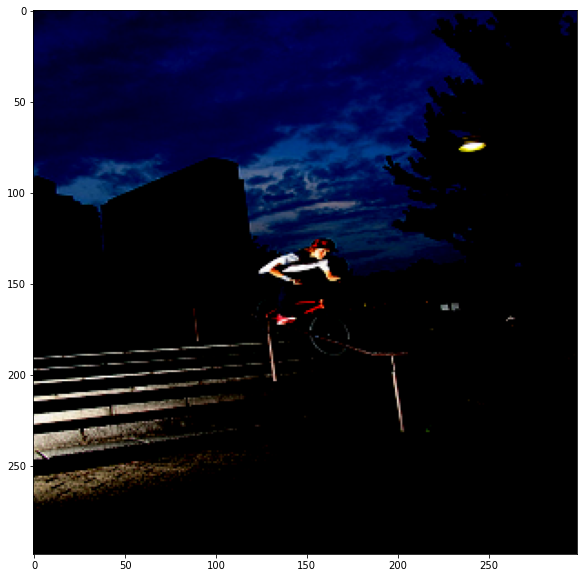

-----Models Output-----
40960/35363 [==================================] - 0s 0us/step


[[('n02835271', 'bicycle-built-for-two', 0.43974605),
  ('n04509417', 'unicycle', 0.16322312),
  ('n02788148', 'bannister', 0.09770592),
  ('n03792782', 'mountain_bike', 0.040460028),
  ('n04482393', 'tricycle', 0.037265457)]]

In [14]:
fig=pyplot.figure(figsize=(10,10))#width ,height
pyplot.imshow(image[0][:,:])
pyplot.show()
print("-----Models Output-----")
decode_predictions(xcep_model.predict(image),top=5)#outputs (class_name, class_description, score)

In [0]:
xcep_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

```See, the last Dense Layer is of 1000 output units.```<br>


```It transforms the 2048 feature weights vector into 1000 output units.```

2.2 **Extracting Features**

```Extract Features for each image and store it in dictionary named "features_dict".```
<br>
```We will use include_top="False" to remove the Top(Dense) Layer. ```

In [13]:
start_time = time.time()
model = Xception( include_top=False, pooling='avg' )

def image_features(image_list):
    features = {}
    total=len(image_list)
    with tqdm(total=total) as pbar:
        for i in tqdm(image_list):
            image = Image.open(image_path+i)
            image=image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[i] = feature
            pbar.update(1)
    return features 
# features_dict=image_features(img_desc_dict)
print("--- %s seconds ---" % (time.time() - start_time))

83689472/83683744 [==============================] - 7s 0us/step
--- 10.724579811096191 seconds ---


In [0]:
model = Xception( include_top=False, pooling='avg' )
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

```So, Now the output of our model is a vector of 2048 weights.```

In [19]:
len(features_dict["3729405438_6e79077ab2.jpg"][0])

2048

```Save the feature weights for each Image.```

In [0]:
# a=[]
# for i in features_dict.keys():
#   for j in features_dict[i]:
#     a.append((i,j))
# np.save(text_path+"features.npy",np.array(a))

```Load the Feature Weights for each Image.```

In [0]:
features=np.load(text_path+"features.npy",allow_pickle=True)
features_dict={}
for a,b in features:
  if a in features_dict.keys():
    features_dict[a].append(b)
  else:
    features_dict[a]=[b]

2.3 **Visualizing the Filters** 

```There are so many Convolution Layers in our model.```
<br> ```Each Convolutional layer contains a set of filters whose parameters are already learnt.```

In [0]:
conv_count=0
for i in range(len(model.layers)):
  layer = model.layers[i]
  if ('conv' not in layer.name) or ('_act' in layer.name) or ('_bn' in layer.name):
          continue
  print(i, layer.name, layer.output.shape)
  conv_count=conv_count+1
print("Total Conv Layers used in xception model is ",conv_count)

1 block1_conv1 (None, None, None, 32)
4 block1_conv2 (None, None, None, 64)
7 block2_sepconv1 (None, None, None, 128)
10 block2_sepconv2 (None, None, None, 128)
12 conv2d_5 (None, None, None, 128)
17 block3_sepconv1 (None, None, None, 256)
20 block3_sepconv2 (None, None, None, 256)
22 conv2d_6 (None, None, None, 256)
27 block4_sepconv1 (None, None, None, 728)
30 block4_sepconv2 (None, None, None, 728)
32 conv2d_7 (None, None, None, 728)
37 block5_sepconv1 (None, None, None, 728)
40 block5_sepconv2 (None, None, None, 728)
43 block5_sepconv3 (None, None, None, 728)
47 block6_sepconv1 (None, None, None, 728)
50 block6_sepconv2 (None, None, None, 728)
53 block6_sepconv3 (None, None, None, 728)
57 block7_sepconv1 (None, None, None, 728)
60 block7_sepconv2 (None, None, None, 728)
63 block7_sepconv3 (None, None, None, 728)
67 block8_sepconv1 (None, None, None, 728)
70 block8_sepconv2 (None, None, None, 728)
73 block8_sepconv3 (None, None, None, 728)
77 block9_sepconv1 (None, None, None, 728)


>```The First Convolution Layer has 32 filters each of window size 3X3.```
<br>
>```Lets get the weights of these filters.```

In [0]:
print("Total Number of Filters",model.layers[1].filters)
model.layers[1].get_weights()[0][:,:,:,0]       #The first 3X3 filter learned by 1st Conv Layer for each RGB Channels.
# model.layers[4].get_weights()[0][:,:,:,0]     #The first 3X3 filter learned by the 2nd Conv Layer for each RGB Channels.

Total Number of Filters 32


array([[[ 0.4018715 ,  0.04848129, -0.41650546],
        [ 0.3894546 , -0.09194137, -0.3265562 ],
        [ 0.4157912 , -0.02777531, -0.3976357 ]],

       [[-0.11647206,  0.06889967,  0.01426533],
        [-1.2329519 ,  0.60815054,  0.72089684],
        [-0.75004053,  0.48014855,  0.3119804 ]],

       [[-0.05341647,  0.18497275, -0.06230718],
        [-1.5801911 ,  0.811841  ,  0.9442127 ],
        [-0.9605914 ,  0.61180437,  0.4687424 ]]], dtype=float32)

>```Each filter is like a 3X3 numpy matrix.``` <br>
>```So we can easily visualise it by plotting as an image.```

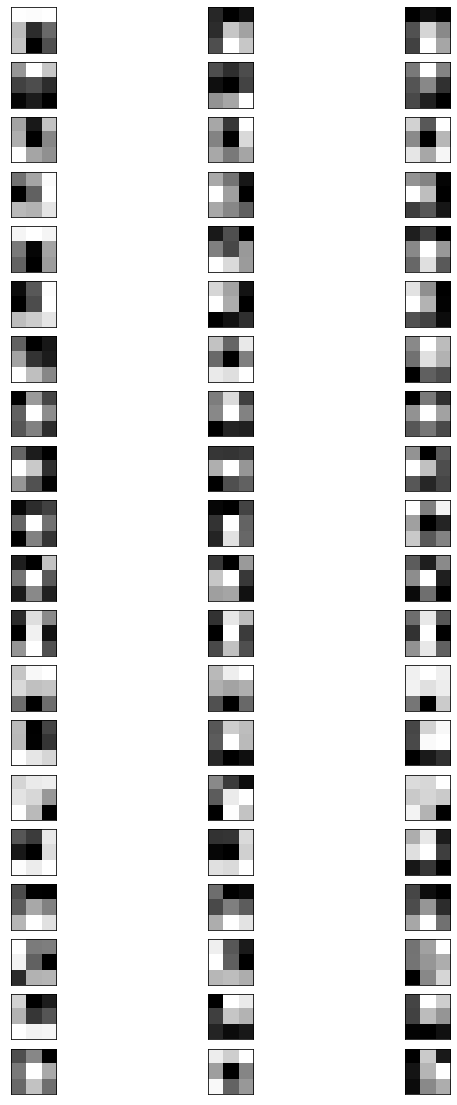

In [0]:
filters=np.array(model.layers[1].get_weights()[0])
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 20, 1                                                       # plot first 20 filters
fig=pyplot.figure(figsize=(10,20))                                          #width ,height
for i in range(n_filters):
	
  f = filters[:, :, :, i]                                                   # get the i'th filter
  for j in range(3):                                                        #3=RGB
    ax = pyplot.subplot(n_filters, 3, ix)      		                          # specify subplot and turn of axis
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.imshow(f[:, :, j], cmap='gray')		                              # plot filter channel in grayscale
    ix += 1
pyplot.show()

>*   ```We can see that in some cases, the filter is the same across the channels,and in others, the filters differs from left to right and top to bottom.```
>*   ```We can also see that the filters on the first row detect a gradient from light in the top to dark in the bottom.```






In [0]:
print(model.layers[1].get_weights()[0].shape)
print(model.layers[1].get_weights()[0][0].shape)
print(model.layers[1].get_weights()[0][0][2].shape)     #third index 
print(model.layers[1].get_weights()[0][0][0][2].shape)

(3, 3, 3, 32)
(3, 3, 32)
(3, 32)
(32,)


In [0]:
model.layers[1].get_weights()[0][:,:,:,31][:,:,2]

array([[0.5840202 , 0.7522367 , 0.37488812],
       [0.753172  , 0.9176013 , 0.6241615 ],
       [0.49560815, 0.7051911 , 0.53743786]], dtype=float32)

In [0]:
len(features_dict["1000268201_693b08cb0e.jpg"][0])
model1 = Xception( include_top=True, pooling='avg' )
model1.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

2.4 **Feature Maps**

*   ```The Feature maps, capture the result of applying the filters to input,which can be the input image or another feature map.```
*   ```It helps in visualising what features are preserved after each convolution layer happens.```



In [0]:
from keras import Model
map_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
i="3729405438_6e79077ab2.jpg"
image = Image.open(image_path+i)
image=image.resize((299,299))
image = np.expand_dims(image, axis=0)
image = image/127.5
image = image - 1.0
feature_map=map_model.predict(image)[0]

In [0]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>]
[<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(None, 2048) dtype=float32>]


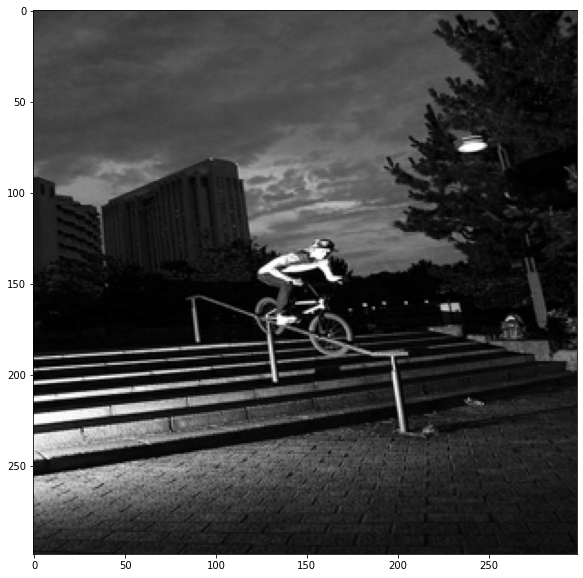

In [0]:
fig=pyplot.figure(figsize=(10,10))
pyplot.imshow(image[0][:,:,0], cmap='gray')

>```We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the  image with different features highlighted.```
<br>
>```Some highlight boundaries/objects, other focus on the background or the foreground.```

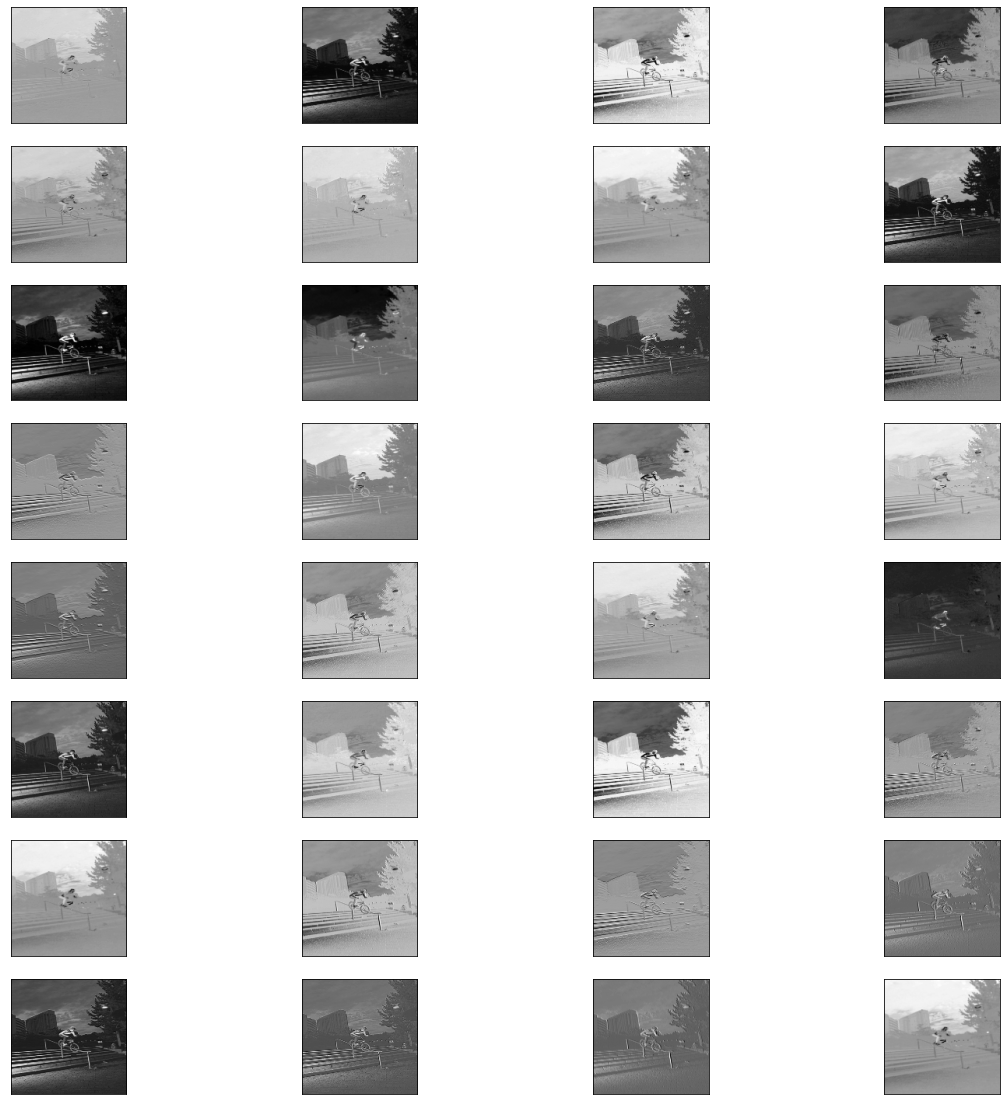

In [0]:
n_filters, ix = 32, 1
fig=pyplot.figure(figsize=(20,20))
for i in range(n_filters):
  f = feature_map[:, :, i]
  ax = pyplot.subplot(n_filters//4,4, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  pyplot.imshow(f[:, :], cmap='gray')
  ix += 1
pyplot.show()

In [0]:
model.summary()
model.output_shape

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

(None, 2048)

>```Let us visualise the feature maps when we go 3 layers deep in CNN.```

In [0]:
ixs = [1,4,7]
model = Xception( include_top=False, pooling='avg' )
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# model.summary()
feature_maps=model.predict(image)
for fmap in feature_maps:
  n_filters, ix = fmap[:,:,:].shape[3], 1
  fig=pyplot.figure(figsize=(20,20))
  for i in range(n_filters):
    f = fmap[ :,:,:, i][0]
    ax = pyplot.subplot(n_filters//8,8, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.imshow(f, cmap='gray')
    ix += 1
  pyplot.show()

Output hidden; open in https://colab.research.google.com to view.

 **Obervations**<br>
```Feature maps closer to the input of the model can capture a lot of fine detail in the image.```<br>
```As going deep,the feature maps show less and less detail.```<br>
>```Also, it is difficult to interpret the deep feature maps.```<br>
>```The deeper layers try to generalise the feature to make model suitable for classification.```<br>
>```The number of filters are increased to learn more complex patterns.Hence, larger combinations of patterns can be captured.```

In [0]:
# model.summary()
outputs

3.**MODEL** 

>*   ```We already know the input for our sequence procesing model.```
>*   ```Also, We have extracted features of each input image.```
>*   ```We will be using both features as an input to our model.``` 



>3.1 <b>Preparing the Input</b>

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def create_squences(desc_list,img_features):
    X2=[]
    X1=[]
    out=[]
    for desc in desc_list:
        seq = tokens.texts_to_sequences([desc])[0]
        for i in range(1,len(seq)):
            in_seq=seq[:i]                                                    #tokenized input sequence
            out_seq=seq[i]                                                    #tokenized output sequence
            in_seq=pad_sequences([in_seq],maxlen=input_max_length)[0]         #padded tokenized input sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]    #categorized output sequence
            X1.append(img_features)
            X2.append(in_seq)
            out.append(out_seq)
    return np.array(X1),np.array(X2),np.array(out)


>```Let us see how input are generated for our model.```

In [22]:
X1,X2,y=create_squences(img_desc_dict["3729405438_6e79077ab2.jpg"],features_dict["3729405438_6e79077ab2.jpg"][0])
print(X1.shape,X2.shape,y.shape)

(46, 2048) (46, 34) (46, 7517)


In [16]:
total_sequence=0
for captions in img_desc_dict["3729405438_6e79077ab2.jpg"]:
  sequence_count=0
  for caption in range(1,len(captions.split(" "))):
    sequence_count=sequence_count+1
    total_sequence=total_sequence+1
  print("Number of sequences formed  with sentence \n{} is {}\n".format(captions,sequence_count))
print("Total Number of sequences formed are",total_sequence)

Number of sequences formed  with sentence 
<start> bicycler balances his bike on rail <end> is 7

Number of sequences formed  with sentence 
<start> biker is riding down the stairs on his bike at night <end> is 12

Number of sequences formed  with sentence 
<start> boy rides his red bicycle down the handrail of staircase in city <end> is 13

Number of sequences formed  with sentence 
<start> guy grinding rail in park on his <end> is 8

Number of sequences formed  with sentence 
<start> trick bicyclist grinds down handrail <end> is 6

Total Number of sequences formed are 46


>```As due to limited RAM capacity ,We cannot generate all the inputs at once as it can cause memory issues while training the model.```<br>
>```As Python Generator have lazy execution ( producing items only when asked for).``` <br>
>```For this reason, a Generator Expression is much memory efficient.```

In [0]:
def data_generator(img_desc_dict):
    while 1:
        for x in img_desc_dict.keys():
            img_features=features_dict[x][0].flatten()
            X1,X2,target_class=create_squences(img_desc_dict[x],img_features)
            yield [[X1,X2],target_class]

In [25]:
a=data_generator(img_desc_dict)
next(a)                                               #call next method on generator to keep generating sequences

[[array([[0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504],
         [0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504],
         [0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504],
         ...,
         [0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504],
         [0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504],
         [0.47339654, 0.01732625, 0.0733396 , ..., 0.08559017, 0.02102292,
          0.23766504]], dtype=float32),
  array([[   0,    0,    0, ...,    0,    0,    2],
         [   0,    0,    0, ...,    0,    2,   41],
         [   0,    0,    0, ...,    2,   41,    3],
         ...,
         [   0,    0,    0, ...,  169,  309,   63],
         [   0,    0,    0, ...,  309,   63,  194],
         [   0,    0,    0, ...,   63,  194, 2886]], dtype=int32)],
 array([[0., 0., 0., ..., 0., 0., 0.],


3.2 **Modelling**<br>

*   ```Our model will take Images Features and Input Sequences as Inputs.```
*   ```It is like a word prediction tasks based on a given sequence.``` 
*   ```The model learns to prediction next word for each given sequences of words.```
*   ```Simply put,```<br>
    ```For a group of sentences belonging to a particular Image,```<br>
    ```For every sentence= [word1,word2,word3,...................,wordn]```
<br>
<br>       <ins>Inputs</ins>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; <ins>Output</ins>
<br>      [word1]&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[word2]
<br>      [word1,word2]&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[word3]
<br>      [word1,word2,..,wordn-1]&emsp;&emsp;&ensp;[wordn] 

<br>

*   ```Training includes which word can be the next word out of the all the 7517 words  included in vocabulary, given the sequence of words and features of image as input.```

*   ```The Supervised Output Sequence in training is a One Hot Encoded Sequence of length 7517 with next word as 1 and rest 0.``` 




>**Part A**
>> ```One Input to the model is output of Xception features of the Image.
  A vector of  2048 dimensions.```<br>
>>```These are compressed to an output vector of 256 dimensions.```

>**Part B**
>>```Input to model is the seqeunces of length = 34.```<br>
>>```There is an Embedding layer of 256 dimensions which maps each word in our vocabulary to vector of 256 dimesions.```<br>
>>```We apply a Lstm layer to our sequences which process sequences in the form of embedding dimensions for each word.```
<br>
>>```The LSTM produces a vector of 256 length learnt from the sequences.``` 

>**Output**
>>```The Final layer is a Dense Layer with 7517 units and sigmoid activation which will compute the probability of each of the 7517 words as next word.```
<br>
```The word with highest proability is taken as next word.```


In [18]:
from keras.utils import plot_model
from keras.layers.merge import add,multiply
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# define the caption model
def build_model(vocab_size, input_max_length):    

    # features from the Xception model squeezed from 2048 to 256 nodes
    feature_inputs = Input(shape=(2048,),name="xception_inputs")
    features_1 = Dropout(0.5)(feature_inputs)
    features_output = Dense(256, activation='relu',name="xception_outputs")(features_1)

    # LSTM sequence model
    seq_inputs = Input(shape=(input_max_length,),name="lstm_inputs")
    seq_embed = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs)
    seq_2 = Dropout(0.5)(seq_embed)
    seq_output = LSTM(256,name="lstm_outputs")(seq_2)


    # Merging both outputs
    comb_outputs = multiply([features_output, seq_output])
    comb_outputs_dense = Dense(256, activation='relu')(comb_outputs)
    outputs = Dense(vocab_size, activation='softmax',name="final_outputs")(comb_outputs_dense)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[feature_inputs, seq_inputs], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model
    
model = build_model(vocab_size, input_max_length)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_inputs (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
xception_inputs (InputLayer)    (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1924352     lstm_inputs[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           xception_inputs[0][0]            
____________________________________________________________________________________________

In [21]:
from keras.callbacks import EarlyStopping
e_s=EarlyStopping(monitor='categorical_crossentropy', patience=2)

print('Dataset: ', len(img_desc_dict))
print('Descriptions: train=', len(img_desc_dict))
print('Vocabulary Size:', vocab_size)                                           #num of target classes
print('Description Length: ', input_max_length)                                 #input length for lstm

epochs = 15
Batch_size=1
steps = len(img_desc_dict)//Batch_size
generator = data_generator(img_desc_dict)
history=model.fit_generator(generator, epochs=epochs, steps_per_epoch= steps, verbose=1,callbacks=[e_s])
model.save(text_path+"../model_25_epochs.h5")

Dataset:  6000
Descriptions: train= 6000
Vocabulary Size: 7517
Description Length:  34
Epoch 1/15
6000/6000 [==============================] - 522s 87ms/step - loss: 2.3949
Epoch 2/15
   2/6000 [..............................] - ETA: 7:57 - loss: 2.3601

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `categorical_crossentropy` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6000/6000 [==============================] - 531s 89ms/step - loss: 2.3878
Epoch 3/15
6000/6000 [==============================] - 542s 90ms/step - loss: 2.3828
Epoch 4/15
6000/6000 [==============================] - 540s 90ms/step - loss: 2.3774
Epoch 5/15
6000/6000 [==============================] - 546s 91ms/step - loss: 2.3751
Epoch 6/15
6000/6000 [==============================] - 532s 89ms/step - loss: 2.3718
Epoch 7/15
6000/6000 [==============================] - 532s 89ms/step - loss: 2.3696
Epoch 8/15
6000/6000 [==============================] - 529s 88ms/step - loss: 2.3627
Epoch 9/15
6000/6000 [==============================] - 535s 89ms/step - loss: 2.3625
Epoch 10/15
6000/6000 [==============================] - 529s 88ms/step - loss: 2.3533
Epoch 11/15
6000/6000 [==============================] - 551s 92ms/step - loss: 2.3516
Epoch 12/15
6000/6000 [==============================] - 558s 93ms/step - loss: 2.3520
Epoch 13/15
6000/6000 [==============================] - 544s 

In [25]:
history.history.keys()
history.history["loss"][0]
epochs

15

3.3 <b>Loss</b>

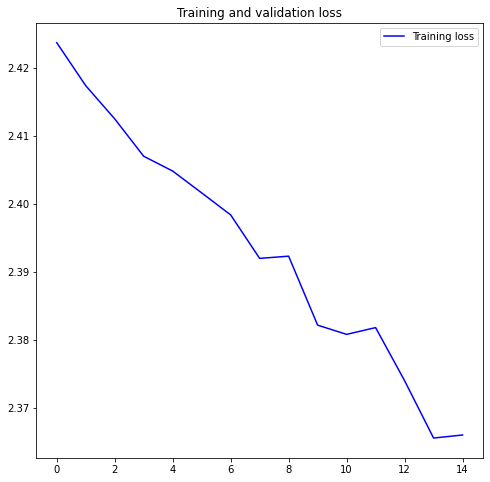

In [23]:
pyplot.figure(figsize = (8, 8))
loss = history.history['loss']
pyplot.plot(range(epochs), loss, 'b', label='Training loss')
pyplot.title('Training and validation loss')
pyplot.legend()

**Prediction for a new Image**

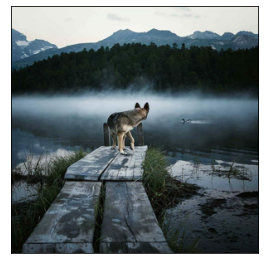

The caption generated for the given image is:- 

 " Dog is running through the water . "


In [24]:
xception_model = Xception( include_top=False, pooling='avg' )
max_length=34
from PIL import Image
def extract_image_features(image):
    image=np.array(image)
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = xception_model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
             return word
    return None

def caption_generator(img):
    photo_features=extract_image_features(img)
    tokenizer=tokens
    in_text = 'start'
    for i in range(max_length):
        in_sequence = tokenizer.texts_to_sequences([in_text])[0]
        in_sequence = pad_sequences([in_sequence], maxlen=max_length)
        pred = model.predict([photo_features,in_sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    in_text=in_text.replace("start","").replace("end","")+"."
    return in_text.strip().capitalize()

img = Image.open(path+"dog_pics.jpeg")
img=img.resize((299,299))
fig=pyplot.figure(figsize=(10,10))
ax = pyplot.subplot(2,1,1)
ax.set_xticks([])
ax.set_yticks([])
pyplot.imshow(img, cmap='gray')
pyplot.show()
caption=caption_generator(img)
print("The caption generated for the given image is:- \n\n \"",caption,"\"")

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```END!```

---



---


